# Scripts for Generating Manuscript Figures

In [ ]:
# Other Files:
# -Airgun data estimates
# -seismic_funcs
# -MGL2104_funcs
# -BPDN processing

In [1]:
import numpy as np
from numpy.matlib import repmat
from matplotlib import pyplot as plt
from scipy import signal as signal
import xarray as xr
import pandas as pd
from MGL2104_funcs import * # Custom functions
from seismic_funcs import * # Custom functions

## Some useful parameters

In [2]:
ci = complex(0,1)
Fs = 500 # Sample rate
c = 1480 # Sound Speed

import cmocean

# Read nav data
nav = readP190_2104('/media/asd21/My Passport/MGL2104_PD12_CSs/MGL2104PD12.0.p190')

# Airgun Array info
srcD = 12
AirgunVols = repmat(np.array([360,360,40,180,90,120,60,220,220]),4,1)
xg = repmat(np.array([-8, -8, -4.77, -2.41, 0.23, 2.69, 5, 8, 8]),4,1) # X positions (along direction of travel)
yg = np.ones([4,9])*np.array([[12],[4],[-4],[-12]]) # Y positions (perpendicular to direction of travel)
zg = repmat(srcD + np.array([0.55, -0.2, -0.2, 0, 0, 0, 0, 0.55, -0.2]),4,1) # Z positions (depth)

## Load Acoustic Data

In [3]:
# Load some previously processed data
# Case 1
SELdata = xr.load_dataset('/media/asd21/My Passport/MGL2104_Layer_Results')
SELall = SELdata['AllRefData']
SELfloor = SELdata['seafloorData']
SELmids = SELdata['midData']
SELcrust = SELdata['crustData']

# Case 2
SELdata = xr.load_dataset('/media/asd21/My Passport/AzureStuff/MGL2104_Layer_Results_WholeTrace2')
SELall2 = SELdata['AllRefData']
SELcrust2 = SELdata['crustData']
SELmids2 = SELdata['midData']
SELfloor2 = SELdata['seafloorData']

# Offset correction
offset = SELdata['offset']+5
shots = SELdata['shot']

SELdata = np.load('/home/asd21/Insync/asd21@uw.edu/Google Drive/Git/seismic/Azure/MGL2104_Layer_Results_SELall_rev2.npy')
SELall3a = SELdata[:,1,:]
SELall3b = SELdata[:,2,:]

freqs = np.array([25,32,40,50,63,80,100,125,159,200]) # One Third Bands
BWs = np.array([6,8,10,12,14,18,24,30,40,40]) # One Third Bandwidths

# Receivers without malfunctions
goodRecInds = np.concatenate( ( np.arange(1,12,1), np.arange(13,16,1), np.arange(17,28,1), np.arange(29,121,1) ) )
goodRecs = np.arange(0,605,5)[goodRecInds]

for fi in range(SELcrust.shape[2]):
    for rec in range(SELcrust.shape[0]):
        tmp = np.copy(SELcrust[rec,:,fi])
        idx = np.where(tmp<0.1*np.mean(tmp))
        SELcrust[rec,idx[0],fi] = np.mean(tmp)
        idx = np.where(np.isnan(tmp))
        SELcrust[rec,idx[0],fi] = np.mean(tmp)
        
        tmp = np.copy(SELall[rec,:,fi])
        idx = np.where(tmp<0.1*np.mean(tmp))
        SELall[rec,idx[0],fi] = np.mean(tmp)
        idx = np.where(np.isnan(tmp))
        SELall[rec,idx[0],fi] = np.mean(tmp)
        
del SELdata

# Figure2: CRG vs. CSG Waterfall Plots

In [4]:
# Load sample data
CRGpth = '/media/asd21/Elements/My Passport Drive/MGL2104_CRG_Samples/MGL2104_CRG_Rec1.nc' # CRG 1
CRGpth2 = '/media/asd21/Elements/My Passport Drive/MGL2104_CRG_Samples/MGL2104_CRG_Rec500.nc' # CRG 500
CMPpth = '/media/asd21/Elements/My Passport Drive/MGL2104_CMPs/CMP_05000.nc' # CMP 
CSGpth = '/media/asd21/Elements/My Passport Drive/MGL2104_PD12_CSs/TAPE0034.REEL/R016202_1623077777.RAW' # Shot 550
CRGdataset = xr.open_dataset(CRGpth)
CRGdata = CRGdataset['Receiver Outputs']
CRGdataset2 = xr.open_dataset(CRGpth2)
CRGdata2 = CRGdataset2['Receiver Outputs']
CMPdataset = xr.open_dataset(CMPpth)
CMPdata = CMPdataset['datafilt']
CSGdata = readSegd_2104(CSGpth)[1].T

t = CMPdata['time']

##### CSG Data #####
# Find location of all receivers
rtmp = np.flip(np.sqrt( (np.array(nav.receiverX[700]) - nav.sourceX[700])**2 + (np.array(nav.receiverY[700]) - nav.sourceY[700])**2 ))

### Create waterfall plot data
recGap = 10
CSGtmp = np.copy(CSGdata)
# Filter
sos = np.array([[1,-2,1,1,-1.82570619168342,0.881881926844246],[1,-2,1,1,-1.65627993129105,0.707242535896459],[1,-2,1,1,-1.57205200320457,0.620422971870477]])
CSGdata = signal.sosfilt(sos,CSGdata,axis=1)
CSGdata = CSGdata
for i in range(len(rtmp)):
    CSGtmp[i,:] = 5e-7*CSGdata[i,:] + rtmp[i]/1e3
    
rCSG = rtmp.copy()


##### CMP Data #####
# Find location of all shots for given receiver
cmp = 5000 # Common Midpoint gather Number
rtmp = np.array(CMPdataset['offset'])

# Create waterfall data
cmpGap = 2
CMPtmp = np.copy(CMPdata)
sos = np.array([[1,-2,1,1,-1.82570619168342,0.881881926844246],[1,-2,1,1,-1.65627993129105,0.707242535896459],[1,-2,1,1,-1.57205200320457,0.620422971870477]])
CMPdata = signal.sosfilt(sos,CMPdata,axis=0)
for i in CMPdataset.rec:
    CMPtmp[i,:] = 5e-7*CMPdata[i,:] + rtmp[i]/1e4
    
rCMP = rtmp.copy()[0:np.size(CMPtmp,0)]
    
##### CRG Data #####
# Find location of all shots for given receiver
rec = 1
x0 = nav.receiverX[0][rec]
y0 = nav.receiverY[0][rec]
rtmp = np.zeros(len(nav.receiverX))
for i in range(1,len(nav.receiverX)):
    xtmp = nav.receiverX[i][rec]
    ytmp = nav.receiverY[i][rec]
    rtmp[i] = np.sqrt( (xtmp-x0)**2 + (ytmp-y0)**2 )
rtmp = np.arange(0,37.5*len(nav.receiverX),37.5)
    
rCRG = rtmp.copy()

# Create waterfall data
shotGap = 15
CRGtmp = np.copy(CRGdata)
for i in range(len(CRGdata['shot'])):
    CRGtmp[i,:] = 1e-6*CRGdata[i,:] + rtmp[i]/1e3
CRGtmp = np.flip(CRGtmp[0:1401,:],0)


##### CRG Data #####
# Find location of all shots for given receiver
rec2 = 500
x02 = nav.receiverX[0][rec2]
y02 = nav.receiverY[0][rec2]
rtmp2 = np.zeros(len(nav.receiverX))
for i in range(1,len(nav.receiverX)):
    xtmp2 = nav.receiverX[i][rec2]
    ytmp2 = nav.receiverY[i][rec2]
    rtmp2[i] = np.sqrt( (xtmp2-x02)**2 + (ytmp2-y02)**2 )
    
rCRG2 = rtmp2.copy()

# Create waterfall data
shotGap = 15
CRGtmp2 = np.copy(CRGdata2)
# CRGdata = np.flip(CRGdata,1)
for i in range(len(CRGdata2['shot'])):
    CRGtmp2[i,:] = 1e-6*CRGdata2[i,:] + rtmp2[i]/1e3
    CRGtmp2 = np.flip(CRGtmp2[0:1401,:],0)

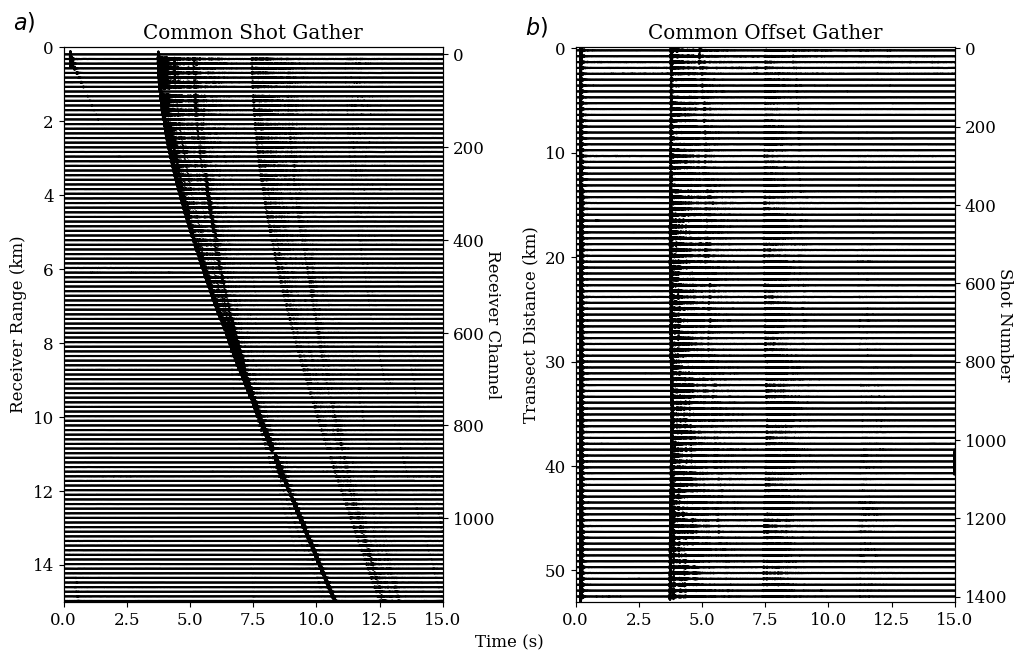

In [5]:
### Generate Plots

plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    
fig = plt.figure(figsize=(11.5,18/5*2))
plt.subplots_adjust(wspace=0.35)# hspace=0.4,left=0.1,bottom=0.1,right=0.9,top=0.9)
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(122)


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(t,CSGtmp[0::recGap,:].T,'k')
ax1a = ax1.twinx()
ax1a.plot(t,CSGtmp[0::recGap,:].T,'k')
ax1a.set_yticks(np.array([rCSG[0],rCSG[200],rCSG[400],rCSG[600],rCSG[800],rCSG[1000],rCSG[-1]])/1e3, labels=[0,200,400,600,800,1000,1200])
ax1.invert_yaxis()
ax1a.invert_yaxis()
ax1.set_xlim([0,15])
ax1a.set_xlim([0,15])
ax1.set_ylim([15,0])
ax1a.set_ylim([15,0])
ax1.set_title('Common Shot Gather')
ax1.set_ylabel('Receiver Range (km)')
ax1a.set_ylabel('Receiver Channel',rotation=-90)

ax3.plot(t,CRGtmp[0::shotGap,:].T,'k')
ax3a = ax3.twinx()
ax3a.plot(t,CRGtmp[0::shotGap,:].T,'k')
ax3a.set_yticks(np.array([0,200,400,600,800,1000,1200,1400])*37.5/1e3, labels=[0,200,400,600,800,1000,1200,1400])
ax3.invert_yaxis()
ax3a.invert_yaxis()
ax3.set_xlim([0,15])
ax3a.set_xlim([0,15])
ax3.set_ylim([53,-0.1])
ax3a.set_ylim([53,-0.1])
ax3.set_title('Common Offset Gather')
ax3.set_ylabel('Transect Distance (km)')
ax3a.set_ylabel('Shot Number',rotation=-90)

ax1.text(-2, -0.5, r'$\it{a})$', fontsize = 16)
ax3.text(-2, -0.5*40/15, r'$\it{b})$', fontsize = 16)

ax.set_xlabel('Time (s)')

plt.show()

## Figure3: Source Signal Estimation

/home/asd21/miniconda3/envs/seismic/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


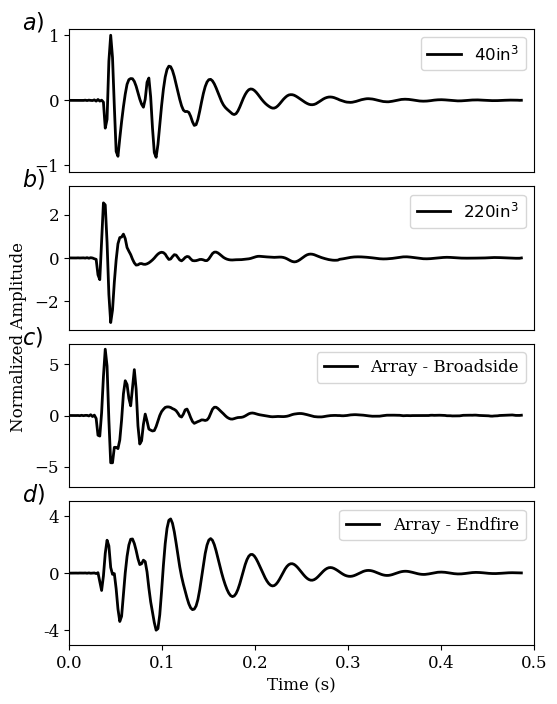

In [6]:
# Load estimated airgun data

AirgunData = np.load('AirgunSigsMGL2104_New.npz')

# Individual airgun sizes
Airgun40 = AirgunData['Airgun40'][0:500]
Airgun60 = AirgunData['Airgun60'][0:500]
Airgun90 = AirgunData['Airgun90'][0:500]
Airgun120 = AirgunData['Airgun120'][0:500]
Airgun180 = AirgunData['Airgun180'][0:500]
Airgun220 = AirgunData['Airgun220'][0:500]
Airgun360 = AirgunData['Airgun360'][0:500]

t_airgun = np.linspace(0,0.975,500)
f = np.fft.fftfreq(500,1/Fs) # Frequency vector

# Airgun parameters
AirgunVols = repmat(np.array([360,360,40,180,90,120,60,220,220]),4,1)
xg = repmat(np.array([-8, -8, -4.77, -2.41, 0.23, 2.69, 5, 8, 8]),4,1)
yg = np.ones([4,9])*np.array([[12],[4],[-4],[-12]])
zg = repmat(srcD + np.array([0.55, -0.2, -0.2, 0, 0, 0, 0, 0.55, -0.2]),4,1)

Airgun40End  = np.fft.ifft(np.fft.fft(Airgun40)*np.exp(ci*2*np.pi*f/c*xg[0][2]))
Airgun60End  = np.fft.ifft(np.fft.fft(Airgun40)*np.exp(ci*2*np.pi*f/c*xg[0][6]))
Airgun90End  = np.fft.ifft(np.fft.fft(Airgun40)*np.exp(ci*2*np.pi*f/c*xg[0][4]))
Airgun120End = np.fft.ifft(np.fft.fft(Airgun40)*np.exp(ci*2*np.pi*f/c*xg[0][5]))
Airgun180End = np.fft.ifft(np.fft.fft(Airgun40)*np.exp(ci*2*np.pi*f/c*xg[0][3]))
Airgun220End = np.fft.ifft(np.fft.fft(Airgun40)*np.exp(ci*2*np.pi*f/c*xg[0][7]))
Airgun360End = np.fft.ifft(np.fft.fft(Airgun40)*np.exp(ci*2*np.pi*f/c*xg[0][0]))

AirgunBroad = 2*Airgun360 + Airgun40 + Airgun180 + Airgun90 + Airgun120 + Airgun60 + 2*Airgun220 # Broadside
AirgunEnd = 2*Airgun360End + Airgun40End + Airgun180End + Airgun90End + Airgun120End + Airgun60End + 2*Airgun220End # Endfire

# Define figure subplots
fig = plt.figure(figsize=(6,8))
plt.subplots_adjust(hspace=0.1)
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# 40 in3 Airgun
ax1.plot(t_airgun[:250],Airgun40[75:325]/np.max(np.abs(Airgun40)),'k',linewidth=2)
ax1.legend([r'$\mathrm{40in^3}$'])
ax1.set_ylim([-1.1,1.1])
ax1.set_xlim([0,0.5])
ax1.set_xticks([])

# Other size (220?)
ax2.plot(t_airgun[:250],Airgun220[75:325]/np.max(np.abs(Airgun40)),'k',linewidth=2)
ax2.legend([r'$\mathrm{220in^3}$'])
ax2.set_ylim([-3.3,3.3])
ax2.set_xlim([0,0.5])
ax2.set_xticks([])

# Broadside signal
ax3.plot(t_airgun[:250],AirgunBroad[75:325]/np.max(np.abs(Airgun40)),'k',linewidth=2)
ax3.legend(['Array - Broadside'])
ax3.set_ylim([-7,7])
ax3.set_xlim([0,0.5])
ax3.set_xticks([])

# Endfire signal
ax4.plot(t_airgun[:250],AirgunEnd[75:325]/np.max(np.abs(Airgun40)),'k',linewidth=2)
ax4.legend(['Array - Endfire'])
ax4.set_ylim([-5,5])
ax4.set_xlim([0,0.5])
ax4.set_yticks([-4,0,4],[-4,0,4])

ax1.text(-0.05, 1.1, r'$\it{a})$', fontsize = 16)
ax2.text(-0.05, 3.3, r'$\it{b})$', fontsize = 16)
ax3.text(-0.05, 7, r'$\it{c})$', fontsize = 16)
ax4.text(-0.05, 5, r'$\it{d})$', fontsize = 16)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized Amplitude')

plt.show()

## Figure 4 - Reflection Inversion on Single Receiver

In [1]:
import matplotlib.gridspec as gridspec

t = np.linspace(0,15,7501) # Time vector
rec = 10
sigma = 0.1 # For Basis Pursuit Denoising

i0 = 0
i1 = 7501
angle = np.arctan((2*2700)/(200+(-rec-2)*12.5))*180/np.pi # Estimated propagation angle
# Source signal estimate
srcSig = np.real(SigExp([xg.flatten(),yg.flatten(),zg.flatten()], AirgunVols.flatten(), angle, ghost=False))
srcSig = srcSig/np.max(srcSig)
srcSig = np.append(srcSig[15:],np.zeros(15))
# Data for inversion
invData = CSGdata[rec,i0:i1]
invData = invData/np.max(np.abs(invData))
invOut = RefInv(invData,srcSig,[20,30],Fs=500,sigma=sigma,iters=1000)

# Plot
fig = plt.figure(figsize=(6,8))
plt.subplots_adjust(hspace=0.1)

gs = gridspec.GridSpec(5,1,height_ratios=[2,2,0.1,2,2])
              
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Time (s)')

# Raw Data
ax1.plot(t[i0:i1],invData,'k',linewidth=2)
ax1.set_ylim([-1.1,1.1])
ax1.set_xlim([0,15])
ax1.set_xticks([])

# Inversion Data
ax2.plot(t[i0:i1],invOut[0:(i1-i0)],'k',linewidth=2)
ax2.set_ylim([-1.1,1.1])
ax2.set_xlim([0,15])
# ax2.set_xticks([])

ax3.remove()

# Index limits
i0 = 1750
i1 = 3501

invData = CSGdata[rec,i0:i1]
invData = invData/np.max(np.abs(invData))
invOut = RefInv(invData,srcSig,[20,60],Fs=500,sigma=sigma,iters=1000)

# Raw Data
ax4.plot(t[i0:i1],invData,'k',linewidth=2)
ax4.set_ylim([-1.1,1.1])
ax4.set_xlim([3.5,7])
ax4.set_xticks([])

# Inversion Data
ax5.plot(t[i0:i1],invOut[0:(i1-i0)],'k',linewidth=2)
ax5.set_ylim([-1.1,1.1])
ax5.set_xlim([3.5,7])

ax1.text(-1.5, 1, r'$\it{a})$', fontsize = 16)
ax2.text(-1.5, 1, r'$\it{b})$', fontsize = 16)
ax4.text(3.5-0.35, 1, r'$\it{c})$', fontsize = 16)
ax5.text(3.5-0.35, 1, r'$\it{d})$', fontsize = 16)

plt.show()


IndentationError: unexpected indent (177727573.py, line 2)

## Figure 5 - Reflection Inversion on full waterfall plot.

In [9]:
# Inversion limits and specs
t = np.linspace(0,15,7501)
rec = 10
i0 = 0
i1 = 7501
sigma = 0.1

angle = np.arctan((2*2700)/(200+(rec-1)*12.5))*180/np.pi
srcSig = np.real(SigExp([xg.flatten(),yg.flatten(),zg.flatten()], AirgunVols.flatten(), angle, ghost=False))
srcSig = srcSig/np.max(srcSig)
srcSig = np.append(srcSig[15:],np.zeros(15))

invOut = np.zeros([np.size(CRGdata,0),int((i1-i0)/2)])
dShot = 15
    
for shot in range(0,1401,dShot):
    invData = CRGdata[shot,i0:i1]
    invOut[shot,:] = 5e-6*RefInv(invData,srcSig,[22,28],Fs=500,sigma=sigma,iters=1000)[0:int((i1-i0)/2)] + rtmp[shot]/1e3

t = np.linspace(0,15,7501)
rec = 500
i0 = 0
i1 = 7501
sigma = 0.1

angle = np.arctan((2*2700)/(200+(rec-1)*12.5))*180/np.pi
srcSig2 = np.real(SigExp([xg.flatten(),yg.flatten(),zg.flatten()], AirgunVols.flatten(), angle, ghost=False))
srcSig2 = srcSig2/np.max(srcSig2)
srcSig2 = np.append(srcSig2[15:],np.zeros(15))

invOut2 = np.zeros([np.size(CRGdata2,0),int((i1-i0)/2)])
dShot = 15
    
for shot in range(0,1401,dShot):
    invData2 = CRGdata2[shot,i0:i1]
    invOut2[shot,:] = 5e-6*RefInv(invData2,srcSig2,[22,28],Fs=500,sigma=sigma,iters=1000)[0:int((i1-i0)/2)] + rtmp[shot]/1e3
    

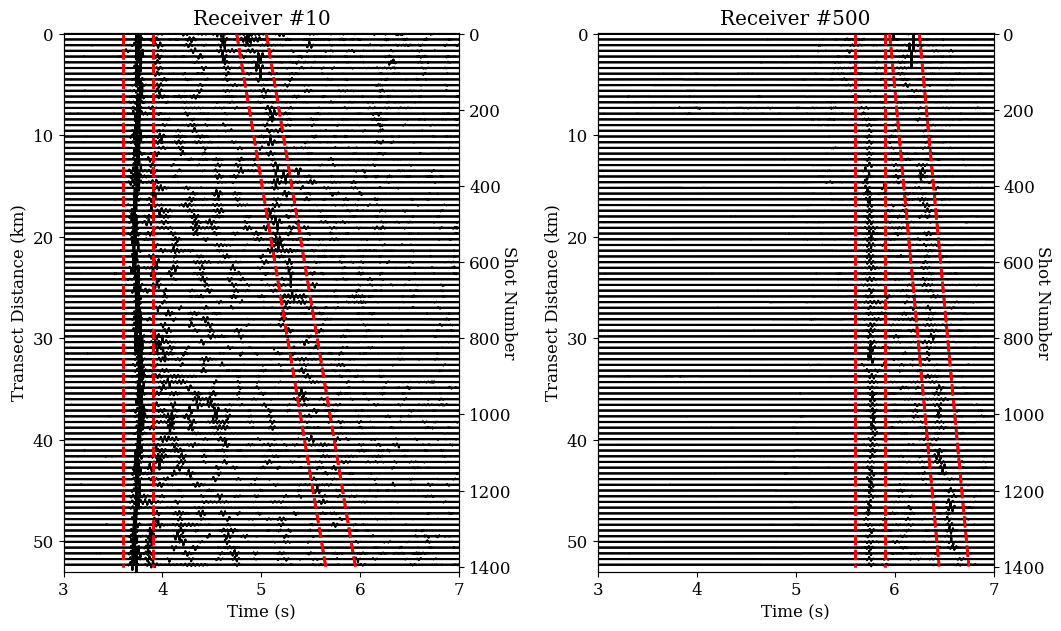

In [10]:
# Plot
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    
fig = plt.figure(figsize=(12,7))
plt.subplots_adjust(wspace=0.35)# hspace=0.4,left=0.1,bottom=0.1,right=0.9,top=0.9)

ax = fig.add_subplot(111)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

tshift = 0.15
line = 'r--'
ax1.plot(t[i0:int(i0+(i1-i0)/2)],invOut[0::dShot,:].T,'k')
ax1a = ax1.twinx()
ax1a.plot(t[i0:int(i0+(i1-i0)/2)],invOut[0::dShot,:].T,'k')
ax1.plot([3.75-tshift,3.75-tshift],[0,52.5],line,linewidth=2)
ax1.plot([4.9-tshift,5.8-tshift],[0,52.5],line,linewidth=2)
ax1a.plot([3.75-tshift,3.75-tshift],[0,52.5],line,linewidth=2)
ax1a.plot([4.9-tshift,5.8-tshift],[0,52.5],line,linewidth=2)
ax1.plot([3.75+tshift,3.75+tshift],[0,52.5],line,linewidth=2)
ax1.plot([4.9+tshift,5.8+tshift],[0,52.5],line,linewidth=2)
ax1a.plot([3.75+tshift,3.75+tshift],[0,52.5],line,linewidth=2)
ax1a.plot([4.9+tshift,5.8+tshift],[0,52.5],line,linewidth=2)
ax1a.set_yticks(np.array([0,200,400,600,800,1000,1200,1400])*37.5/1e3, labels=[0,200,400,600,800,1000,1200,1400])
ax1.invert_yaxis()
ax1a.invert_yaxis()
ax1.set_xlim([3,7])
ax1a.set_xlim([3,7])
ax1.set_ylim([53,-0.1])
ax1a.set_ylim([53,-0.1])
ax1.set_xlabel('Time (s)')
ax1.set_title('Receiver #10')
ax1.set_ylabel('Transect Distance (km)')
ax1a.set_ylabel('Shot Number',rotation=-90)

ax2.plot(t[i0:int(i0+(i1-i0)/2)],invOut2[0::dShot,:].T,'k')
ax2a = ax2.twinx()
ax2a.plot(t[i0:int(i0+(i1-i0)/2)],invOut2[0::dShot,:].T,'k')
ax2.plot([5.75-tshift,5.75-tshift],[0,52.5],line,linewidth=2)
ax2.plot([6.1-tshift,6.6-tshift],[0-tshift,52.5-tshift],line,linewidth=2)
ax2a.plot([5.75-tshift,5.75-tshift],[0,52.5],line,linewidth=2)
ax2a.plot([6.1-tshift,6.6-tshift],[0,52.5],line,linewidth=2)
ax2.plot([5.75+tshift,5.75+tshift],[0,52.5],line,linewidth=2)
ax2.plot([6.1+tshift,6.6+tshift],[0-tshift,52.5-tshift],line,linewidth=2)
ax2a.plot([5.75+tshift,5.75+tshift],[0,52.5],line,linewidth=2)
ax2a.plot([6.1+tshift,6.6+tshift],[0,52.5],line,linewidth=2)
ax2a.set_yticks(np.array([0,200,400,600,800,1000,1200,1400])*37.5/1e3, labels=[0,200,400,600,800,1000,1200,1400])
ax2.invert_yaxis()
ax2a.invert_yaxis()
ax2.set_xlim([3,7])
ax2a.set_xlim([3,7])
ax2.set_ylim([53,-0.1])
ax2a.set_ylim([53,-0.1])
ax2.set_xlabel('Time (s)')
ax2.set_title('Receiver #500')
ax2.set_ylabel('Transect Distance (km)')
ax2a.set_ylabel('Shot Number',rotation=-90)

plt.show()

## Figures 6 and 7 - Surf Plots of SEL vs shot & rec (or range & range) (2 frequencies?)

In [11]:
# Load departure angle calculations
SimpleAngles = np.load('Simple_Angles.npz')['arr_0']
RefractedAngles = np.load('Refracted_Angles.npz')['arr_0']
SpeedFinal = np.load('SpeedFinal.npz')['arr_0']

# Depths
SrcRecD = 12
D = 2600

# Straight Line Angles
angles = np.arange(0.1,90,0.1)
Rng_Simple = 2*(D - SrcRecD)/np.tan(angles/180*np.pi)

# Refracting Line Angles
dDepth = 1
ang_i = 0
Rng_Ref = np.zeros(len(angles))
for angle in angles:
    th1 = angle/180*np.pi
    Rtot = 0
    for d in np.arange(int(SrcRecD),int(D),1):
        c1 = SpeedFinal[d]
        c2 = SpeedFinal[d+1]
        th2 = np.arccos(c2/c1*np.cos(th1))
        dR = dDepth/np.tan(th2)
        th1 = th2
        Rtot += dR
    Rng_Ref[ang_i] = Rtot
    ang_i += 1

/home/asd21/miniconda3/envs/seismic/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/tmp/ipykernel_78594/3584448806.py:87: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(ims1,pad=0.1,ticks=[190, 195, 200, 205, 210, 215, 220])


Full Reflection 25 Hz Band


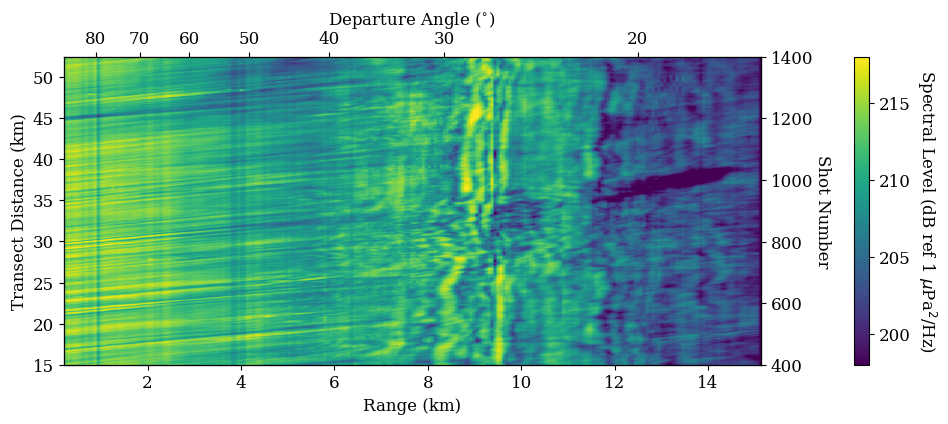

Full Time Trace


/tmp/ipykernel_78594/3584448806.py:112: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(ims1,pad=0.1,ticks=[200, 205, 210, 215, 220, 225])


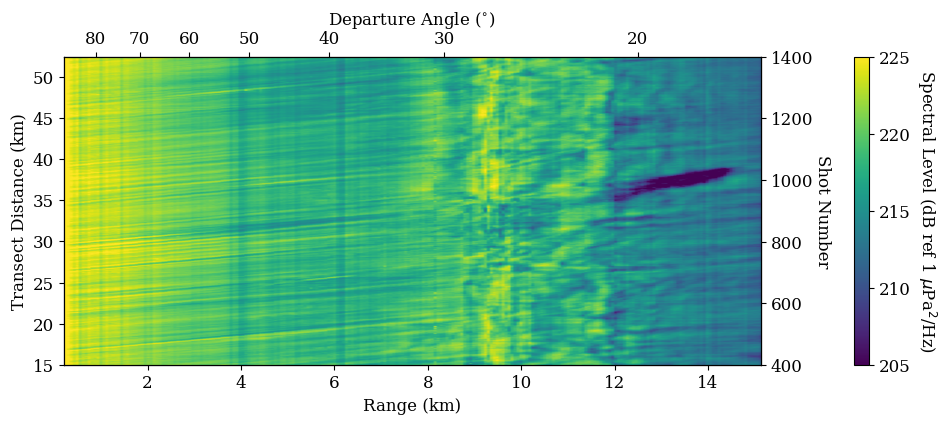

Full Time Trace 25 Hz Band


/tmp/ipykernel_78594/3584448806.py:137: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(ims1,pad=0.1,ticks=[190, 195, 200, 205, 210, 215, 220])


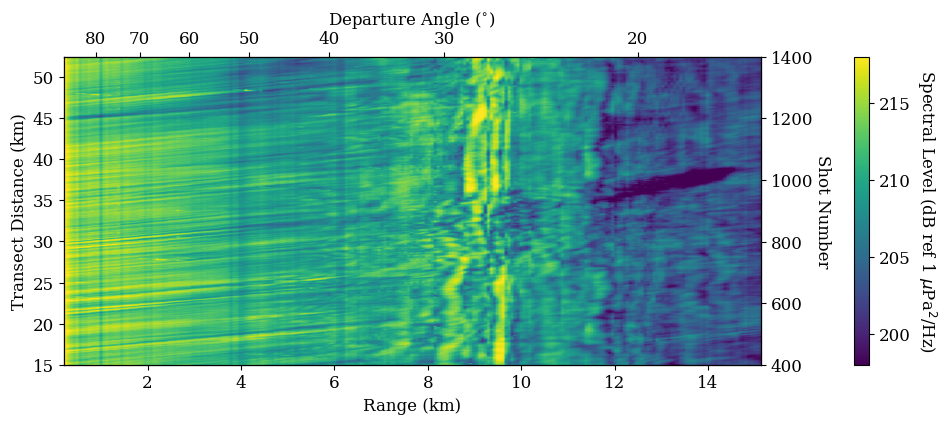

Seafloor Reflection


/tmp/ipykernel_78594/3584448806.py:162: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(ims1,pad=0.1)


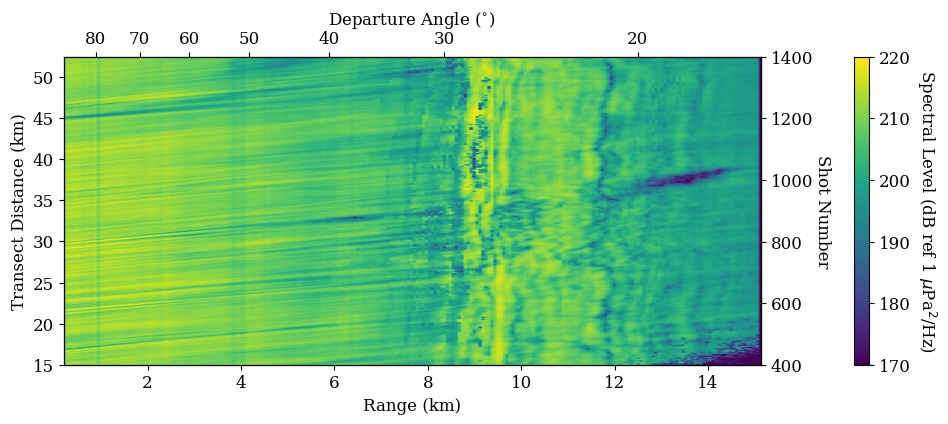

Middle Layers


/tmp/ipykernel_78594/3584448806.py:187: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(ims1,pad=0.1)


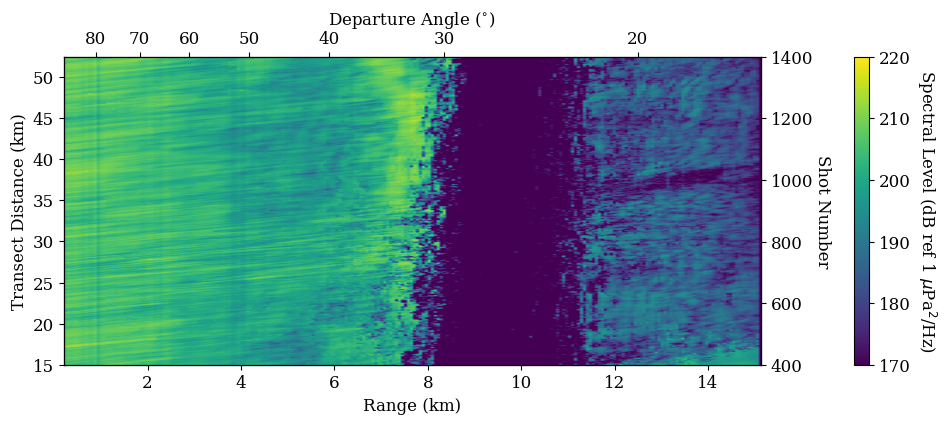

Crust


/tmp/ipykernel_78594/3584448806.py:213: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(ims1,pad=0.1)


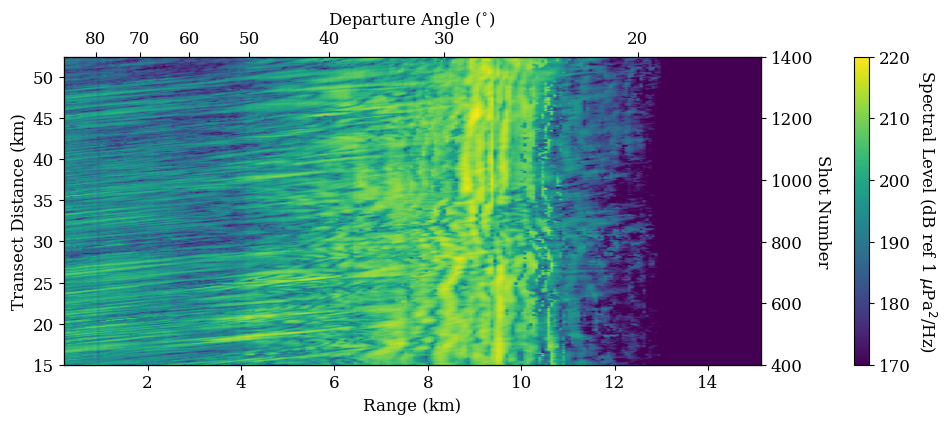

In [13]:
cmapName = 'viridis' 

AngleTicks = [   80,   70,   60,   50,   40,   30,    20]
RangeTicks = [0.898,1.852,2.928,4.234,5.952,8.462,12.662]

fi = 0
i = 0
shotLims = [400,1400]
CMPshots = np.arange(shotLims[0],shotLims[1])
nShots = 97

cLimsdB = [198,218]
cLimsdB2 = [205,225]
cLimsdB3 = [198,218]
cLimsdB4 = [170,220]
gauss_sig = 0
CMPFlag = 'Off'

# receivers to plot
recInds = np.concatenate( ( np.arange(1,15,1) , np.arange(16,27,1) , np.arange(28,147,1) , np.arange(148,171,1) , np.arange(172,200,1) , np.arange(201,240,1) ) )
recInds2 = np.concatenate( ( np.arange(1,145,1) , np.arange(146,151,1) , np.arange(152,157,1) , np.arange(158,240,1) ) )
goodRecInds2 = np.arange(0,240,1)
goodRecs2 = np.arange(0,1200,5)[goodRecInds2]
offset2 = 200 + np.arange(0,1200,5)*12.5

dataAll = []

# Data for creating surface plots

dataSurf = np.array(20*np.log10(SELall2[:,shotLims[0]:shotLims[1],fi].T/(1e-6))) + 10*np.log10(5.7692)
dataSurf[dataSurf<cLimsdB[0]] = cLimsdB[0]
dataSurf[dataSurf>cLimsdB[1]] = cLimsdB[1]
dataSurf = dataSurf[:,recInds]
dataAll.append(dataSurf)

dataSurf = np.array(20*np.log10(SELall3a[:,shotLims[0]:shotLims[1]].T/(1e-6))) + 10*np.log10(5.7692)
dataSurf[dataSurf<cLimsdB2[0]] = cLimsdB2[0]
dataSurf[dataSurf>cLimsdB2[1]] = cLimsdB2[1]
dataSurf = dataSurf[:,recInds2]
dataAll.append(dataSurf)

dataSurf = np.array(20*np.log10(SELall3b[:,shotLims[0]:shotLims[1]+1].T/(1e-6))) + 10*np.log10(5.7692)
dataSurf[dataSurf<cLimsdB3[0]] = cLimsdB3[0]
dataSurf[dataSurf>cLimsdB3[1]] = cLimsdB3[1]
dataSurf = dataSurf[:,recInds2]
dataAll.append(dataSurf)
shotLims = [CMPshots[0],CMPshots[-1]]
    
dataSurf = np.array(20*np.log10(SELfloor2[:,shotLims[0]:shotLims[1]+1,fi].T/(1e-6))) + 10*np.log10(5.7692)
dataSurf[dataSurf<cLimsdB4[0]] = cLimsdB4[0]
dataSurf[dataSurf>cLimsdB4[1]] = cLimsdB4[1]
dataSurf = dataSurf[:,recInds]
dataAll.append(dataSurf)
shotLims = [CMPshots[0],CMPshots[-1]]

dataSurf = np.array(20*np.log10(SELmids2[:,shotLims[0]:shotLims[1]+1,fi].T/(1e-6))) + 10*np.log10(5.7692)
dataSurf[dataSurf<cLimsdB4[0]] = cLimsdB4[0]
dataSurf[dataSurf>cLimsdB4[1]] = cLimsdB4[1]
dataSurf = dataSurf[:,recInds]
dataAll.append(dataSurf)
shotLims = [CMPshots[0],CMPshots[-1]]

dataSurf = np.array(20*np.log10(SELcrust2[:,shotLims[0]:shotLims[1]+1,fi].T/(1e-6))) + 10*np.log10(5.7692)
dataSurf[dataSurf<cLimsdB4[0]] = cLimsdB4[0]
dataSurf[dataSurf>cLimsdB4[1]] = cLimsdB4[1]
dataSurf = dataSurf[:,recInds]
dataAll.append(dataSurf)
shotLims = [CMPshots[0],CMPshots[-1]]

    
print('Full Reflection 25 Hz Band')
    
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)
ims1 = plt.imshow(np.flip(dataAll[0],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB[0],vmax=cLimsdB[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400*37.5/1e3])
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ims1a = ax1a.imshow(np.flip(dataAll[0],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB[0],vmax=cLimsdB[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400])
# ims1 = ax1.contourf(offset2[recInds]/1e3,CMPshots,dataAll[0],cmap=cmapName,levels=np.linspace(cLimsdB[0],cLimsdB[1],51))
ax1.set_ylim([15,shotLims[1]*37.5/1e3])
ax1.set_xlim([offset2[0]/1e3,offset2[-1]/1e3])
ax1.set_ylabel('Transect Distance (km)')
ax1.set_xlabel('Range (km)')
ax1a.set_ylim([shotLims[0],(shotLims[1]+1)])
ax1a.set_ylabel('Shot Number',rotation=-90)
# ax1b.set_xticks(np.array([0.970, 2.004, 3.179, 4.621, 6.560, 9.540, 15.130])/(15.1375),[80,70,60,50,40,30,20])
ax1b.set_xticks((np.array(RangeTicks)-0.2)/15.1375,AngleTicks)
# ax1b.set_xticks(np.array([0.970, 2.00, 3.179, 4.621, 6.560, 9.540, 15.130])-0.2,[80,70,60,50,40,30,20])
ax1b.set_xlabel('Departure Angle ($^{\circ}$)')
# plt.title('Full Reflection 25 Hz Band')
cbar = plt.colorbar(ims1,pad=0.1,ticks=[190, 195, 200, 205, 210, 215, 220])
cbar.set_label('Spectral Level (dB ref 1 $\mu$Pa$^2$/Hz)', rotation=270, labelpad=20)
ax1a.yaxis.set_label_coords(1.1, 0.5)
plt.show()


print('Full Time Trace')

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)
ims1 = plt.imshow(np.flip(dataAll[1],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB2[0],vmax=cLimsdB2[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400*37.5/1e3])
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ims1a = ax1a.imshow(np.flip(dataAll[1],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB2[0],vmax=cLimsdB2[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400])
# ims1 = ax1.contourf(offset2[recInds]/1e3,CMPshots,dataAll[1],cmap=cmapName,levels=np.linspace(cLimsdB[0],cLimsdB[1],51))
ax1.set_ylim([15,shotLims[1]*37.5/1e3])
ax1.set_xlim([offset2[0]/1e3,offset2[-1]/1e3])
ax1.set_ylabel('Transect Distance (km)')
ax1.set_xlabel('Range (km)')
ax1a.set_ylim([shotLims[0],(shotLims[1]+1)])
ax1a.set_ylabel('Shot Number',rotation=-90)
ax1b.set_xticks((np.array(RangeTicks)-0.2)/15.1375,AngleTicks)
# ax1b.set_xticks(np.array([0.970, 2.00, 3.179, 4.621, 6.560, 9.540, 15.130])-0.2,[80,70,60,50,40,30,20])
ax1b.set_xlabel('Departure Angle ($^{\circ}$)')
# plt.title('Full Time Trace')
cbar = plt.colorbar(ims1,pad=0.1,ticks=[200, 205, 210, 215, 220, 225])
cbar.set_label('Spectral Level (dB ref 1 $\mu$Pa$^2$/Hz)', rotation=270, labelpad=20)
ax1a.yaxis.set_label_coords(1.1, 0.5)
plt.show()


print('Full Time Trace 25 Hz Band')

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)
ims1 = plt.imshow(np.flip(dataAll[2],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB3[0],vmax=cLimsdB3[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400*37.5/1e3])
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ims1a = ax1a.imshow(np.flip(dataAll[2],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB3[0],vmax=cLimsdB3[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400])
# ims1 = ax1.contourf(offset2[recInds2]/1e3,CMPshots,dataAll[2],cmap=cmapName,levels=np.linspace(cLimsdB[0],cLimsdB[1],51))
ax1.set_ylim([15,shotLims[1]*37.5/1e3])
ax1.set_xlim([offset2[0]/1e3,offset2[-1]/1e3])
ax1.set_ylabel('Transect Distance (km)')
ax1.set_xlabel('Range (km)')
ax1a.set_ylim([shotLims[0],(shotLims[1]+1)])
ax1a.set_ylabel('Shot Number',rotation=-90)
ax1b.set_xticks((np.array(RangeTicks)-0.2)/15.1375,AngleTicks)
# ax1b.set_xticks(np.array([0.970, 2.00, 3.179, 4.621, 6.560, 9.540, 15.130])-0.2,[80,70,60,50,40,30,20])
ax1b.set_xlabel('Departure Angle ($^{\circ}$)')
# plt.title('Full Time Trace 25 Hz Band')
cbar = plt.colorbar(ims1,pad=0.1,ticks=[190, 195, 200, 205, 210, 215, 220])
cbar.set_label('Spectral Level (dB ref 1 $\mu$Pa$^2$/Hz)', rotation=270, labelpad=20)
ax1a.yaxis.set_label_coords(1.1, 0.5)
plt.show()


print('Seafloor Reflection')

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)
ims1 = plt.imshow(np.flip(dataAll[3],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB4[0],vmax=cLimsdB4[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400*37.5/1e3])
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ims1a = ax1a.imshow(np.flip(dataAll[3],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB4[0],vmax=cLimsdB4[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400])
# ims1 = ax1.contourf(offset2[recInds]/1e3,CMPshots,dataAll[3],cmap=cmapName,levels=np.linspace(cLimsdB[0],cLimsdB[1],51))
ax1.set_ylim([15,shotLims[1]*37.5/1e3])
ax1.set_xlim([offset2[0]/1e3,offset2[-1]/1e3])
ax1.set_ylabel('Transect Distance (km)')
ax1.set_xlabel('Range (km)')
ax1a.set_ylim([shotLims[0],(shotLims[1]+1)])
ax1a.set_ylabel('Shot Number',rotation=-90)
ax1b.set_xticks((np.array(RangeTicks)-0.2)/15.1375,AngleTicks)
# ax1b.set_xticks(np.array([0.970, 2.00, 3.179, 4.621, 6.560, 9.540, 15.130])-0.2,[80,70,60,50,40,30,20])
ax1b.set_xlabel('Departure Angle ($^{\circ}$)')
# plt.title('Seafloor')
cbar = plt.colorbar(ims1,pad=0.1)
cbar.set_label('Spectral Level (dB ref 1 $\mu$Pa$^2$/Hz)', rotation=270, labelpad=20)
ax1a.yaxis.set_label_coords(1.1, 0.5)
plt.show()


print('Middle Layers')

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)
ims1 = plt.imshow(np.flip(dataAll[4],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB4[0],vmax=cLimsdB4[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400*37.5/1e3])
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ims1a = ax1a.imshow(np.flip(dataAll[4],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB4[0],vmax=cLimsdB4[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400])
# ims1 = ax1.contourf(offset2[recInds]/1e3,CMPshots,dataAll[4],cmap=cmapName,levels=np.linspace(cLimsdB[0],cLimsdB[1],51))
ax1.set_ylim([15,shotLims[1]*37.5/1e3])
ax1.set_xlim([offset2[0]/1e3,offset2[-1]/1e3])
ax1.set_ylabel('Transect Distance (km)')
ax1.set_xlabel('Range (km)')
ax1a.set_ylim([shotLims[0],(shotLims[1]+1)])
ax1a.set_ylabel('Shot Number',rotation=-90)
ax1b.set_xticks((np.array(RangeTicks)-0.2)/15.1375,AngleTicks)
# ax1b.set_xticks(np.array([0.970, 2.00, 3.179, 4.621, 6.560, 9.540, 15.130])-0.2,[80,70,60,50,40,30,20])
ax1b.set_xlabel('Departure Angle ($^{\circ}$)')
# plt.title('Middle Layers')
cbar = plt.colorbar(ims1,pad=0.1)
cbar.set_label('Spectral Level (dB ref 1 $\mu$Pa$^2$/Hz)', rotation=270, labelpad=20)
ax1a.yaxis.set_label_coords(1.1, 0.5)
plt.show()


print('Crust')

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)
ims1 = plt.imshow(np.flip(dataAll[5],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB4[0],vmax=cLimsdB4[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400*37.5/1e3])
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ims1a = ax1a.imshow(np.flip(dataAll[5],axis=0),cmap=cmapName,aspect='auto',vmin=cLimsdB4[0],vmax=cLimsdB4[1],extent=[offset2[0]/1e3,offset2[-1]/1e3,400,1400])
# ims1 = ax1.contourf(offset2[recInds]/1e3,CMPshots,dataAll[5],cmap=cmapName,levels=np.linspace(cLimsdB[0],cLimsdB[1],51))
ax1.set_ylim([15,shotLims[1]*37.5/1e3])
ax1.set_xlim([offset2[0]/1e3,offset2[-1]/1e3])
ax1.set_ylabel('Transect Distance (km)')
ax1.set_xlabel('Range (km)')
ax1a.set_ylim([shotLims[0],(shotLims[1]+1)])
ax1a.set_ylabel('Shot Number',rotation=-90)
ax1b.set_xticks((np.array(RangeTicks)-0.2)/15.1375,AngleTicks)
# ax1b.set_xticks(np.array([0.970, 2.00, 3.179, 4.621, 6.560, 9.540, 15.130])-0.2,[80,70,60,50,40,30,20])
# ax1b.set_xticks([0.1,0.2,0.3,0.4,0.6,0.7,0.8],[80,70,60,50,40,30,20])
ax1b.set_xlabel('Departure Angle ($^{\circ}$)')
# plt.title('Crust')
cbar = plt.colorbar(ims1,pad=0.1)
cbar.set_label('Spectral Level (dB ref 1 $\mu$Pa$^2$/Hz)', rotation=270, labelpad=20)
ax1a.yaxis.set_label_coords(1.1, 0.5)
plt.show()


## Figure 8 - Line Plots of SEL for each layer relative to full volume


In [14]:
nShots = 1000
i = 0
fi = 0
xLims = [0,16]
yLims = [120,200]
titles = ['Full Reflection','Full Output','Full Output 25 Hz','Seafloor Reflection','Mid Layers Reflection','Crust Reflection']
spread = 0

# Make line plots
yLims = [-30,0]

allLine = []

allLine.append(np.array(SELall2[recInds,400:,fi].T))
allLine.append(np.array(SELall3a[recInds2,400:1401].T))
allLine.append(np.array(SELall3b[recInds2,400:1401].T))
    
for tmpdata in [SELfloor2,SELmids2,SELcrust2]:
    
    tmpdata = tmpdata / ( SELfloor2 + SELmids2 + SELcrust2 ) * 1e-6
    dataLine = np.array(tmpdata[recInds,400:,fi].T)
    allLine.append(dataLine)
    i += 1
                             
recIndsAll = [recInds,recInds2,recInds2,recInds,recInds,recInds]
fitInds1 = [np.concatenate(( np.arange(0,80,1)  , np.arange(-50,-1,1) )),
           np.concatenate(( np.arange(10,80,1) , np.arange(-50,-1,1) )),
           np.concatenate(( np.arange(0,100,1) , np.arange(-30,-1,1) )),
           np.concatenate(( np.arange(0,80,1)  , np.arange(-50,-1,1) )),
           np.concatenate(( np.arange(0,50,1)  , np.arange(-20,-1,1) )),
           np.arange(0,30,1)]
fitInds2 = [np.arange(0,80,1),np.arange(10,80,1),np.arange(0,100,1),
            np.arange(0,80,1),np.arange(0,50,1),np.arange(0,30,1)]
fitInds3 = [np.arange(-50,-1,1),np.arange(-50,-1,1),np.arange(-30,-1,1),np.arange(-50,-1,1),np.arange(-20,-1,1),np.arange(0,30,1)]

legend = ['8.7log(r)','5.8log(r)','7.0log(r)','10.2log(r)','28.3log(r)','48.8log(r)']
legend1 = ['8.1log(r)','6.5log(r)','7.7log(r)','10.3log(r)','15.6log(r)','11.2log(r)']
legend2 = ['11.5log(r)','14.2log(r)','10.4log(r)','12.5log(r)','16.4log(r)','11.2log(r)']
legend3 = ['7.3log(r)','7.4log(r)','2.5log(r)','21.8log(r)','21.8log(r)','11.2log(r)']
legend4 = ['10log(r)','10log(r)','10log(r)','10log(r)','10log(r)','10log(r)']

/tmp/ipykernel_78594/2129953749.py:9: RuntimeWarning: divide by zero encountered in log10
  dataMeandB = 20*np.log10(dataMean/(1e-6))
/tmp/ipykernel_78594/2129953749.py:10: RuntimeWarning: divide by zero encountered in log10
  dataLowdB = 20*np.log10((dataMean-dataStd)/(1e-6))
/tmp/ipykernel_78594/2129953749.py:11: RuntimeWarning: divide by zero encountered in log10
  dataHighdB = 20*np.log10((dataMean+dataStd)/(1e-6))
/tmp/ipykernel_78594/2129953749.py:12: RuntimeWarning: divide by zero encountered in log10
  dataScatdB = 20*np.log10(allLine[ii]/(1e-6))


Full Reflection


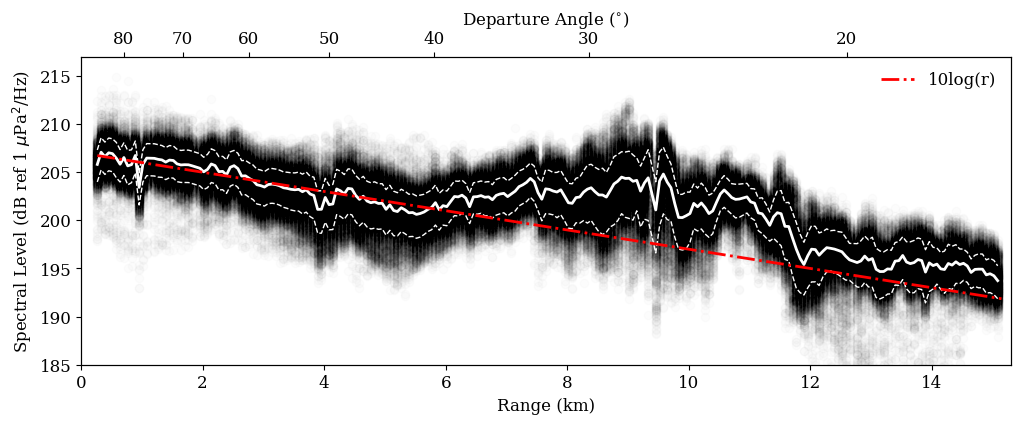

Full Output


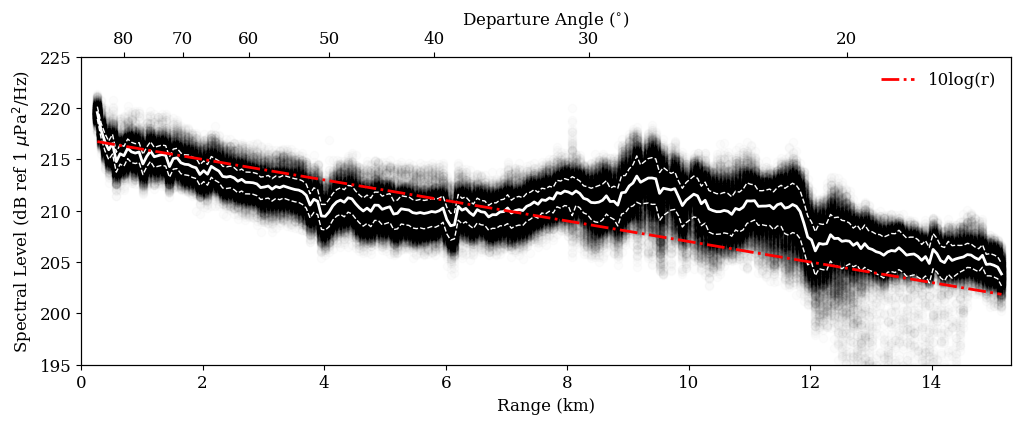

Full Output 25 Hz


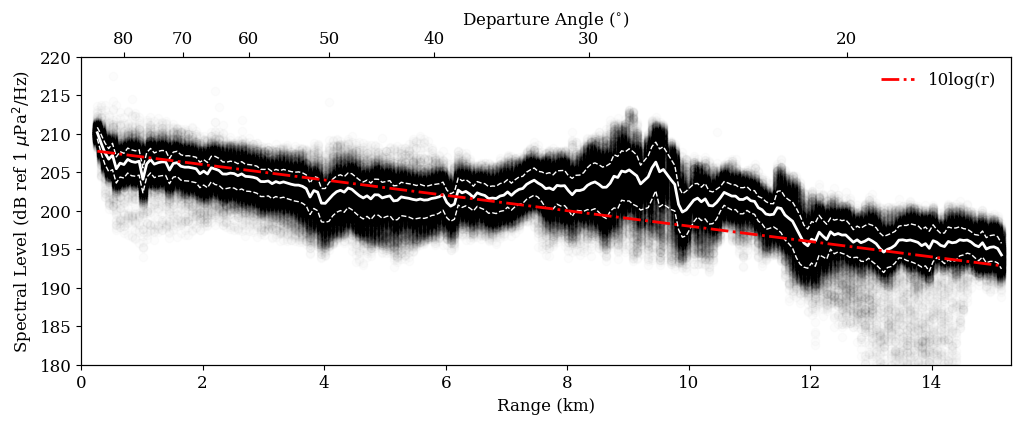

In [15]:
dBmin = [185,195,180]
dBmax = [217,225,220]
bfit4All = [207,217,208]

for ii in range(len(allLine[0:3])):   

    dataMean = np.mean(allLine[ii],axis=0)
    dataStd = np.std(allLine[ii],axis=0)
    dataMeandB = 20*np.log10(dataMean/(1e-6))
    dataLowdB = 20*np.log10((dataMean-dataStd)/(1e-6))
    dataHighdB = 20*np.log10((dataMean+dataStd)/(1e-6))
    dataScatdB = 20*np.log10(allLine[ii]/(1e-6))

    fitdB = dataMeandB.copy()
    fitdB[fitdB < 100] = 100
    afit, bfit = np.polyfit(offset[recIndsAll[ii]], fitdB, 1)
    afit1, bfit1 = np.polyfit(offset[recIndsAll[ii]][fitInds1[ii]], fitdB[fitInds1[ii]], 1)
    afit2, bfit2 = np.polyfit(offset[recIndsAll[ii]][fitInds2[ii]], fitdB[fitInds2[ii]], 1)
    afit3, bfit3 = np.polyfit(offset[recIndsAll[ii]][fitInds3[ii]], fitdB[fitInds3[ii]], 1)
    afit4 = -0.001
    bfit4 = bfit4All[ii]


    print(titles[ii])

    fig = plt.figure(figsize=(12,4))
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    ax = fig.add_subplot(111)
    plt.subplots_adjust(hspace=0.1)
    for i in range(nShots):
        ax.scatter(offset[recIndsAll[ii]]/1e3,dataScatdB[i,:],c='k',alpha=0.01)
    ax.plot(offset[recIndsAll[ii]]/1e3,dataMeandB,'w',linewidth=2)
    ax.plot(offset[recIndsAll[ii]]/1e3,dataLowdB,'w--',linewidth=1)
    ax.plot(offset[recIndsAll[ii]]/1e3,dataHighdB,'w--',linewidth=1)
    line1, = ax.plot(offset[recIndsAll[ii]]/1e3, afit4*offset[recIndsAll[ii]]+bfit4,'r-.',linewidth=2)
    ax.set_xlim([0,15.3])
    ax.set_ylim([dBmin[ii],dBmax[ii]])
    ax.set_ylabel('Spectral Level (dB ref 1 $\mu$Pa$^2$/Hz)')
    ax.set_xlabel('Range (km)')
    ax.set_xticks([0,2,4,6,8,10,12,14],[0,2,4,6,8,10,12,14])
    axb = ax.twiny()
    axb.set_xticks((np.array(RangeTicks)-0.2)/15.1375,AngleTicks)
    axb.set_xlabel('Departure Angle ($^{\circ}$)')
    ax.legend([line1],[legend4[ii]],frameon=False)
    plt.show()      
    

/tmp/ipykernel_78594/424290798.py:16: RuntimeWarning: divide by zero encountered in log10
  dataScatdB = 20*np.log10(allLine[jj]/(1e-6))


Seafloor Reflection


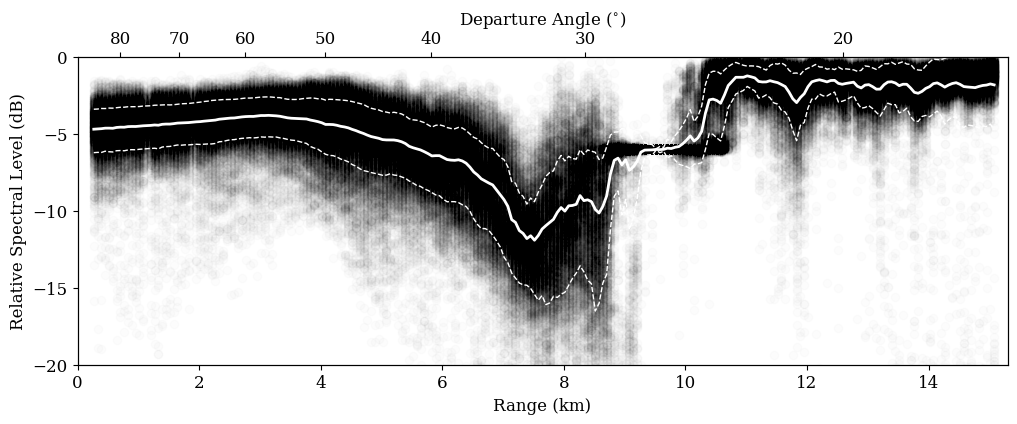

/tmp/ipykernel_78594/424290798.py:13: RuntimeWarning: divide by zero encountered in log10
  dataMeandB = 20*np.log10(dataMean/(1e-6))
/tmp/ipykernel_78594/424290798.py:14: RuntimeWarning: divide by zero encountered in log10
  dataLowdB = 20*np.log10((dataMean-dataStd)/(1e-6))
/tmp/ipykernel_78594/424290798.py:14: RuntimeWarning: invalid value encountered in log10
  dataLowdB = 20*np.log10((dataMean-dataStd)/(1e-6))
/tmp/ipykernel_78594/424290798.py:15: RuntimeWarning: divide by zero encountered in log10
  dataHighdB = 20*np.log10((dataMean+dataStd)/(1e-6))


Mid Layers Reflection


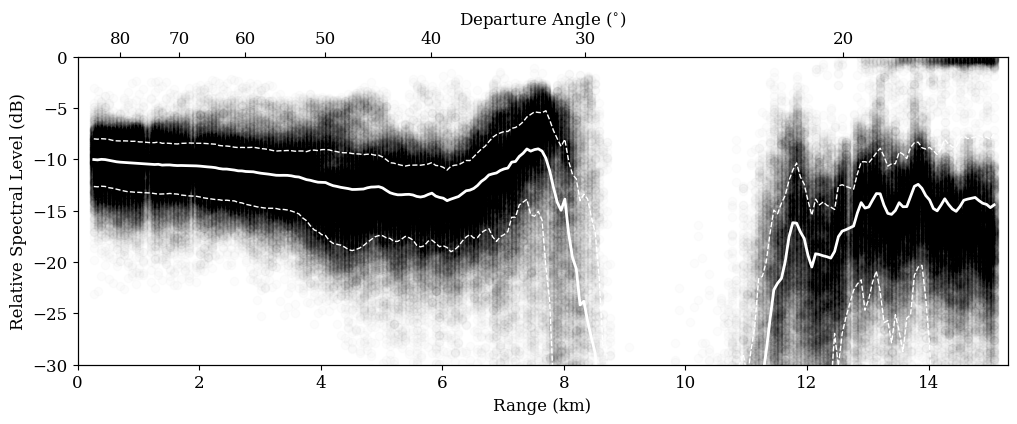

Crust Reflection


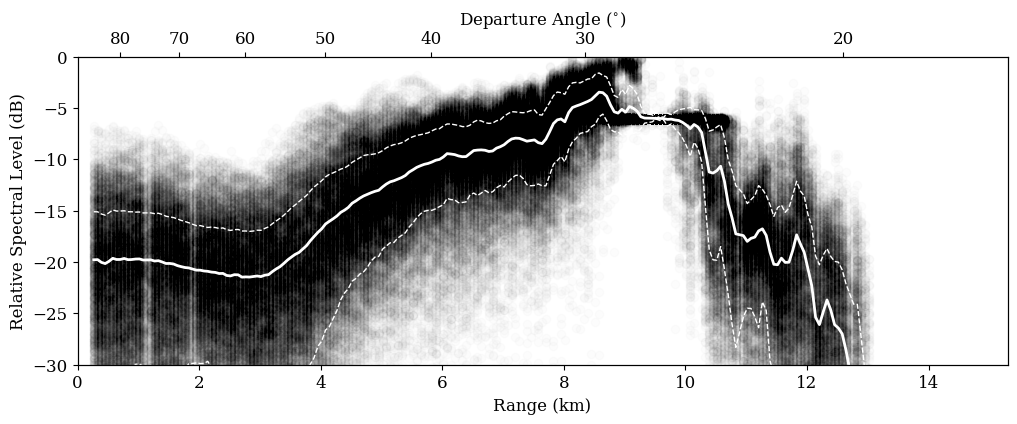

In [16]:
# Re-plot with relative levels

dBmin = [-20,-30,-30]
dBmax = [0,0,0]
bfit4All = [0,0,0]
pctTick  = [ [0,0.2385,0.5,0.699,0.8495,1.0] , [  0, 0.333,0.492,0.667, 0.799,0.9,1.0] , [  0, 0.333,0.492,0.667, 0.799,0.9,1.0] ]
pctLabel = [ [1,     3, 10,   25,    50,100] , [0.1,     1,    3,   10,    25, 50,100] , [0.1,     1,    3,   10,    25, 50,100] ]
yTicks = [ [-20,-15,-10,-5,0] , [-30,-25,-20,-15,-10,-5,0] , [-30,-25,-20,-15,-10,-5,0] ]

for ii in range(len(allLine[3:])):   

    jj = ii + 3
    dataMean = np.mean(allLine[jj],axis=0)
    dataStd = np.std(allLine[jj],axis=0)
    dataMeandB = 20*np.log10(dataMean/(1e-6))
    dataLowdB = 20*np.log10((dataMean-dataStd)/(1e-6))
    dataHighdB = 20*np.log10((dataMean+dataStd)/(1e-6))
    dataScatdB = 20*np.log10(allLine[jj]/(1e-6))

    print(titles[jj])

    fig = plt.figure(figsize=(12,4))
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    ax = fig.add_subplot(111)
    plt.subplots_adjust(hspace=0.1)
    for i in range(nShots):
        ax.scatter(offset[recIndsAll[jj]]/1e3,dataScatdB[i,:],c='k',alpha=0.01)
    ax.plot(offset[recIndsAll[jj]]/1e3,dataMeandB,'w',linewidth=2)
    ax.plot(offset[recIndsAll[jj]]/1e3,dataLowdB,'w--',linewidth=1)
    ax.plot(offset[recIndsAll[jj]]/1e3,dataHighdB,'w--',linewidth=1)
    ax.set_xlim([0,15.3])
    ax.set_ylim([dBmin[ii],dBmax[ii]])
    ax.set_ylabel('Relative Spectral Level (dB)')
    ax.set_xlabel('Range (km)')
    ax.set_xticks([0,2,4,6,8,10,12,14],[0,2,4,6,8,10,12,14])
    ax.set_yticks(yTicks[ii])
    axb = ax.twiny()
    axb.set_xticks((np.array(RangeTicks)-0.2)/15.1375,AngleTicks)
    axb.set_xlabel('Departure Angle ($^{\circ}$)')
    plt.show()      

## Figure 9 - Plot Averages

/tmp/ipykernel_78594/2923649373.py:36: RuntimeWarning: divide by zero encountered in log10
  dataMeandB = 10*np.log10(dataMean)
/tmp/ipykernel_78594/2923649373.py:39: RuntimeWarning: divide by zero encountered in log10
  dataScatdB = 10*np.log10(allLine[ii])
/tmp/ipykernel_78594/2923649373.py:54: RuntimeWarning: divide by zero encountered in log10
  dataMeandB = 10*np.log10(dataMean)
/tmp/ipykernel_78594/2923649373.py:57: RuntimeWarning: divide by zero encountered in log10
  dataScatdB = 10*np.log10(allLine[ii])
/tmp/ipykernel_78594/2923649373.py:65: RuntimeWarning: divide by zero encountered in log10
  dataMeandB = 10*np.log10(dataMean)
/tmp/ipykernel_78594/2923649373.py:68: RuntimeWarning: divide by zero encountered in log10
  dataScatdB = 10*np.log10(allLine[ii])


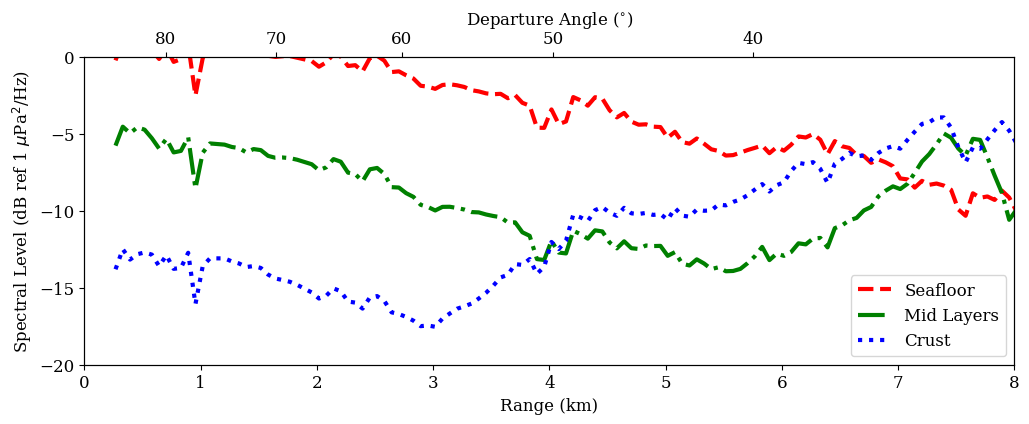

In [17]:
nShots = 1000
i = 0
fi = 0
xLims = [0,16]
yLims = [120,200]
titles = ['Full Reflection','Full Output','Full Output 25 Hz','Seafloor Reflection','Mid Layers Reflection','Crust Reflection']
spread = 0

# Make line plots
yLims = [-30,0]

allLine = []

allLine.append(np.array(SELall2[recInds,400:,fi].T))
allLine.append(np.array(SELall3a[recInds2,400:1401].T))
allLine.append(np.array(SELall3b[recInds2,400:1401].T))
    
for tmpdata in [SELfloor2,SELmids2,SELcrust2]:
    
    tmpdata = tmpdata#/SELall2 #*1e-6
    dataLine = np.array( (tmpdata[recInds,400:,fi].T)**2 / np.mean( SELfloor2[recInds,400:,fi].T + SELmids2[recInds,400:,fi].T + SELcrust2[recInds,400:,fi].T )**2 )
    allLine.append(dataLine)
    i += 1

#'Seafloor Reflection'

ii = 3

dataMean = np.mean(allLine[ii],axis=0)
# dataStd = np.std(allLine[ii],axis=0)
dataMeandB = 10*np.log10(dataMean)
# dataLowdB = 20*np.log10((dataMean-dataStd))
# dataHighdB = 20*np.log10((dataMean+dataStd)/(1e-6))
dataScatdB = 10*np.log10(allLine[ii])

fig = plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
ax = fig.add_subplot(111)
plt.subplots_adjust(hspace=0.1)

ax.plot(offset[recInds]/1e3,dataMeandB,'r--',linewidth=3)

ii = 4

dataMean = np.mean(allLine[ii],axis=0)
# dataStd = np.std(allLine[ii],axis=0)
dataMeandB = 10*np.log10(dataMean)
# dataLowdB = 20*np.log10((dataMean-dataStd)/(1e-6))
# dataHighdB = 20*np.log10((dataMean+dataStd)/(1e-6))
dataScatdB = 10*np.log10(allLine[ii])

ax.plot(offset[recInds]/1e3,dataMeandB,'g-.',linewidth=3)

ii = 5

dataMean = np.mean(allLine[ii],axis=0)
# dataStd = np.std(allLine[ii],axis=0)
dataMeandB = 10*np.log10(dataMean)
# dataLowdB = 20*np.log10((dataMean-dataStd)/(1e-6))
# dataHighdB = 20*np.log10((dataMean+dataStd)/(1e-6))
dataScatdB = 10*np.log10(allLine[ii])

ax.plot(offset[recInds]/1e3,dataMeandB,'b:',linewidth=3)

ax.set_xlim([0,8])
ax.set_ylim([-15,0])
ax.set_ylabel('Spectral Level (dB ref 1 $\mu$Pa$^2$/Hz)')
ax.set_xticks([])
ax.set_yticks([-20,-15,-10,-5,0])
ax.set_xticks([0,1,2,3,4,5,6,7,8],[0,1,2,3,4,5,6,7,8])
axb = ax.twiny()
axb.set_xticks((np.array(RangeTicks[:-2])-0.2)/8,AngleTicks[:-2])
axb.set_xlabel('Departure Angle ($^{\circ}$)')
ax.legend(['Seafloor','Mid Layers','Crust'])
ax.set_xlabel('Range (km)')
plt.show()    
              

## Figure - Line Plots of relative SEL at each frequency band

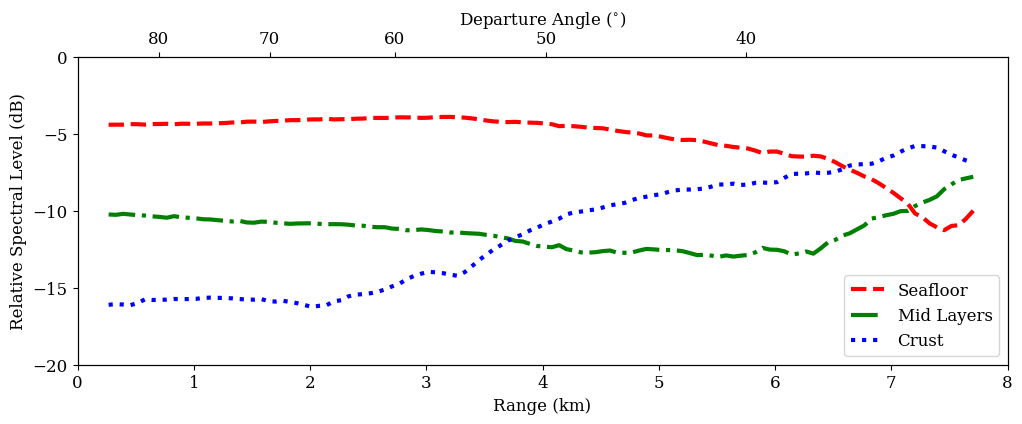

In [20]:
#'Seafloor Reflection'

fig = plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
ax = fig.add_subplot(111)
plt.subplots_adjust(hspace=0.1)
ax.plot(offset[goodRecInds]/1e3,dataMeandB_a[1],'r--',linewidth=3)
ax.plot(offset[goodRecInds]/1e3,dataMeandB_a[2],'g-.',linewidth=3)
ax.plot(offset[goodRecInds]/1e3,dataMeandB_a[3],'b:',linewidth=3)
ax.set_xlim([0,8])
ax.set_ylim([-15,0])
ax.set_ylabel('Relative Spectral Level (dB)')
ax.set_xticks([])
ax.set_yticks([-20,-15,-10,-5,0])
ax.set_xticks([0,1,2,3,4,5,6,7,8],[0,1,2,3,4,5,6,7,8])
axb = ax.twiny()
axb.set_xticks((np.array(RangeTicks[:-2])-0.2)/8,AngleTicks[:-2])
axb.set_xlabel('Departure Angle ($^{\circ}$)')
ax.legend(['Seafloor','Mid Layers','Crust'])
ax.set_xlabel('Range (km)')
plt.show()    


## Figure 11 - Crust Reflection Analysis

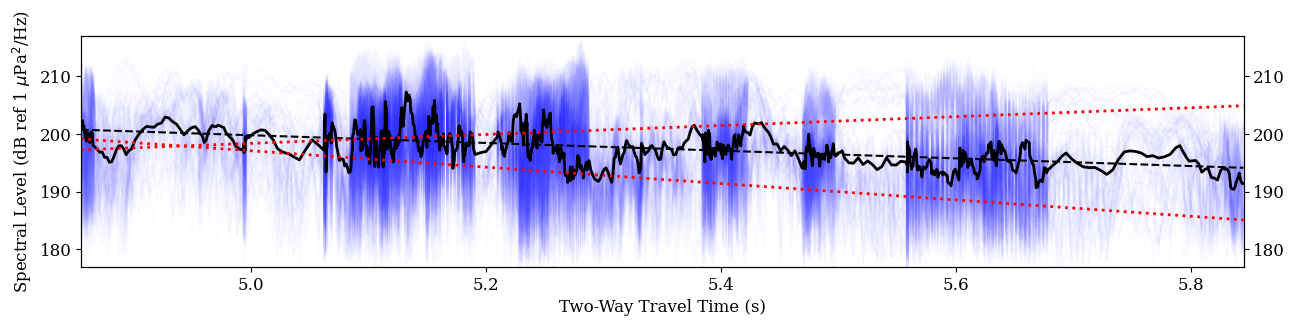

In [21]:

plt.rcParams.update({'font.size': 12})

fi = 0

d1 = 3700
d2 = 4500
dCMP = np.linspace(d1,d2,1303)
shotStart = 0

import pandas as pd

plotData = pd.read_csv('plot-data.csv')

shotData = np.array(plotData['x'])
depthData = np.array(plotData[' y'])
perm = shotData.argsort()
shotData = shotData[perm]
shotData[0] = 0
shotData[-1] = 1303
depthData = depthData[perm]

shotDataInt = np.arange(0,1303,1)
depthDataInt = np.interp(shotDataInt,shotData,depthData)
depthDataInt400 = depthDataInt[360:]
perm2 = depthDataInt.argsort()
perm400 = depthDataInt400.argsort()
depthDataInt = depthDataInt[perm2]
depthDataInt400 = depthDataInt400[perm400]


dataCrust = np.array(20*np.log10(SELcrust[goodRecInds,:,fi].T*offset[goodRecInds]**0/(1e-6))) + 10*np.log10(5.76)
dataCrust,CMPshots = CSGtoCMP(dataCrust,goodRecs,Shot0=0,Shot1=1400,nShots=97)
dataCrust = dataCrust[shotStart:,:]
dataCrustMean = np.mean(dataCrust,axis=1)

# Plotting a range of SEL vs crust and fit lines
fig = plt.figure(figsize=(15,3))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
ax0 = fig.add_subplot(111)

aAll = []
bAll = []
# for rec in range(tmp0,tmp1):
for rec in range(dataCrust.shape[1]):
    a0, b0 = np.polyfit(depthDataInt, dataCrust[perm2,rec],1)
    aAll.append(a0)
    bAll.append(b0)
    ax0.plot(depthDataInt,dataCrust[perm2,rec],'b',alpha=0.01)
    ax0.set_xlim([depthDataInt[0],depthDataInt[-1]])
idxMin = np.argmin(aAll)
idxMax = np.argmax(aAll)

a, b = np.polyfit(depthDataInt, dataCrustMean[perm2],1)

ax0.plot(depthDataInt,dataCrustMean,'k',alpha=1,linewidth=2)
ax0.plot(depthDataInt,a*depthDataInt+b,'k--',alpha=1)
ax0.plot(depthDataInt,aAll[idxMax]*depthDataInt+bAll[idxMax],'r:',alpha=1,linewidth=2)
ax0.plot(depthDataInt,aAll[idxMin]*depthDataInt+bAll[idxMin],'r:',alpha=1,linewidth=2)
ax0.set_xlabel('Two-Way Travel Time (s)')
ax0.set_ylabel('Spectral Level (dB ref 1 $\mu$Pa$^2$/Hz)')
ax1 = ax0.twinx()
ax0.set_yticks([180,190,200,210])
ax0.set_ylim([177,217])
ax1.set_yticks([180,190,200,210])
ax1.set_ylim([177,217])
plt.show()


## Figure 12 - Slope vs receiver channel

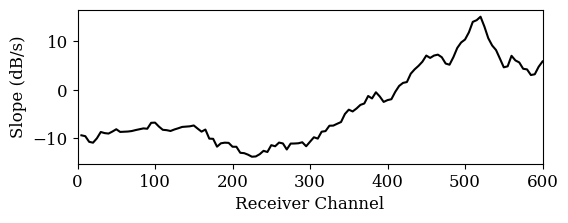

In [22]:

# Plotting a range of SEL vs crust and fit lines
a_all = np.zeros(len(goodRecInds))
b_all = np.zeros(len(goodRecInds))
for rec in range(len(goodRecInds)):
    a_all[rec], b_all[rec] = np.polyfit(depthDataInt, dataCrust[perm2,rec],1)
    
dataCrust = np.array(20*np.log10(SELcrust[goodRecInds,:,fi].T*offset[goodRecInds]**0/(1e-6)))
dataCrust400,CMPshots400 = CSGtoCMP(dataCrust,goodRecs,Shot0=360,Shot1=1400,nShots=97)

a_all400 = np.zeros(len(goodRecInds))
b_all400 = np.zeros(len(goodRecInds))
for rec in range(len(goodRecInds)):
    a_all400[rec], b_all400[rec] = np.polyfit(depthDataInt400, dataCrust400[perm400,rec],1)

fig = plt.figure(figsize=(6,2))
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.plot(goodRecInds*5,a_all400,'k')
plt.xlabel('Receiver Channel')
plt.ylabel('Slope (dB/s)')
plt.xlim([0,600])
plt.rcParams.update({'font.size': 12})
plt.show()


# Figure 14 - Slope vs. Receiver channel for all frequency bands

In [23]:
slopes1400 = []
slopes400 = []

plt.rcParams.update({'font.size': 12})

for fi in range(10):

    d1 = 3700
    d2 = 4500
    dCMP = np.linspace(d1,d2,1303)
    shotStart = 0

    import pandas as pd

    plotData = pd.read_csv('plot-data.csv')

    shotData = np.array(plotData['x'])
    depthData = np.array(plotData[' y'])
    perm = shotData.argsort()
    shotData = shotData[perm]
    shotData[0] = 0
    shotData[-1] = 1303
    depthData = depthData[perm]

    shotDataInt = np.arange(0,1303,1)
    depthDataInt = np.interp(shotDataInt,shotData,depthData)
    depthDataInt400 = depthDataInt[360:]
    perm2 = depthDataInt.argsort()
    perm400 = depthDataInt400.argsort()
    depthDataInt = depthDataInt[perm2]
    depthDataInt400 = depthDataInt400[perm400]

    dataCrust = np.array(20*np.log10(SELcrust[goodRecInds,:,fi].T*offset[goodRecInds]**0/(1e-6)))
    dataCrust,CMPshots = CSGtoCMP(dataCrust,goodRecs,Shot0=0,Shot1=1400,nShots=97)
    dataCrust = dataCrust[shotStart:,:]
    dataCrustMean = np.mean(dataCrust,axis=1)

    aAll = []
    bAll = []
    for rec in range(dataCrust.shape[1]):
        a0, b0 = np.polyfit(depthDataInt, dataCrust[perm2,rec],1)
        aAll.append(a0)
        bAll.append(b0)
        ax0.plot(depthDataInt,dataCrust[perm2,rec],'k',alpha=0.01)
        ax0.set_xlim([depthDataInt[0],depthDataInt[-1]])
    idxMin = np.argmin(aAll)
    idxMax = np.argmax(aAll)

    a, b = np.polyfit(depthDataInt, dataCrustMean[perm2],1)

    # Plotting a range of SEL vs crust and fit lines
    a_all = np.zeros(len(goodRecInds))
    b_all = np.zeros(len(goodRecInds))
    for rec in range(len(goodRecInds)):
        a_all[rec], b_all[rec] = np.polyfit(depthDataInt, dataCrust[perm2,rec],1)

    dataCrust = np.array(20*np.log10(SELcrust[goodRecInds,:,fi].T*offset[goodRecInds]**0/(1e-6)))
    dataCrust400,CMPshots400 = CSGtoCMP(dataCrust,goodRecs,Shot0=360,Shot1=1400,nShots=97)

    a_all400 = np.zeros(len(goodRecInds))
    b_all400 = np.zeros(len(goodRecInds))
    for rec in range(len(goodRecInds)):
        a_all400[rec], b_all400[rec] = np.polyfit(depthDataInt400, dataCrust400[perm400,rec],1)
    
    slopes1400.append(a_all)
    slopes400.append(a_all400)
    

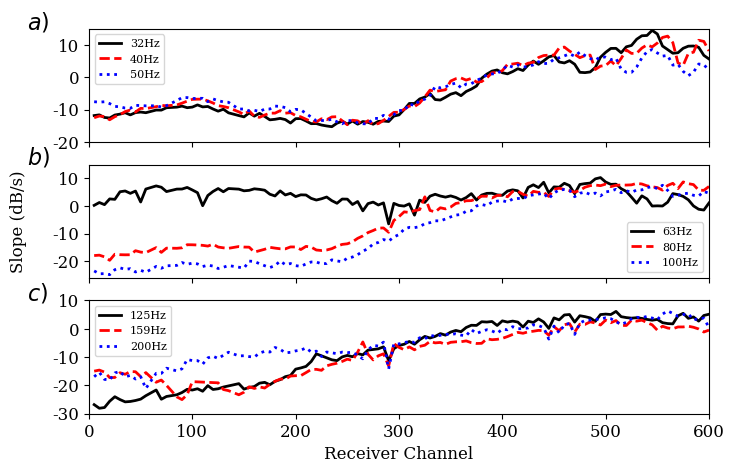

In [24]:
fig = plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
ax = fig.add_subplot(111)
ax4 = fig.add_subplot(311)
ax5 = fig.add_subplot(312)
ax6 = fig.add_subplot(313)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

bad7 = 41
bad8 = 18

ax4.plot(goodRecInds*5,slopes400[1],'k',linewidth=2)
ax4.plot(goodRecInds*5,slopes400[2],'r--',linewidth=2)
ax4.plot(goodRecInds*5,slopes400[3],'b:',linewidth=2)
ax5.plot(goodRecInds*5,slopes400[4],'k',linewidth=2)
ax5.plot(goodRecInds*5,slopes400[5],'r--',linewidth=2)
ax5.plot(goodRecInds*5,slopes400[6],'b:',linewidth=2)
ax6.plot( np.concatenate((goodRecInds[:bad7]*5 , goodRecInds[bad7+2:]*5)) , np.concatenate((slopes400[7][:bad7] , slopes400[7][bad7+2:])) ,'k',linewidth=2)
ax6.plot( np.concatenate((goodRecInds[:bad8]*5 , goodRecInds[bad8+4:]*5)) , np.concatenate((slopes400[8][:bad8] , slopes400[8][bad8+4:])) ,'r--',linewidth=2)
ax6.plot(goodRecInds*5,slopes400[9],'b:',linewidth=2)

ax4.set_xlim([0,600])
ax4.set_ylim([-20,15])
ax4.set_xticks([0,100,200,300,400,500,600],[])
ax4.set_yticks([-20,-10,0,10],[-20,-10,0,10])
ax5.set_xlim([0,600])
ax5.set_ylim([-26,15])
ax5.set_xticks([0,100,200,300,400,500,600],[])
ax5.set_yticks([-20,-10,0,10],[-20,-10,0,10])
ax6.set_xlim([0,600])
ax6.set_ylim([-30,10])
ax6.set_yticks([-30,-20,-10,0,10],[-30,-20,-10,0,10])

plt.rcParams.update({'font.size': 8})
ax4.legend(['32Hz','40Hz','50Hz'])
ax5.legend(['63Hz','80Hz','100Hz'])
ax6.legend(['125Hz','159Hz','200Hz'])

plt.rcParams.update({'font.size': 12})

ax.set_xlabel('Receiver Channel')
ax.set_ylabel('Slope (dB/s)')
ax.yaxis.set_label_coords(-0.1, 0.5)

ax4.text(-60, 15, r'$\it{a})$', fontsize = 16)
ax5.text(-60, 15, r'$\it{b})$', fontsize = 16)
ax6.text(-60, 10, r'$\it{c})$', fontsize = 16)

plt.show()
    

# Figure 13 - Simulated Ray Path

/tmp/ipykernel_78594/782022165.py:64: RuntimeWarning: invalid value encountered in arcsin
  alpha = np.pi/2 - np.arcsin( c2/c1 * np.sin(np.pi/2 - alpha) )


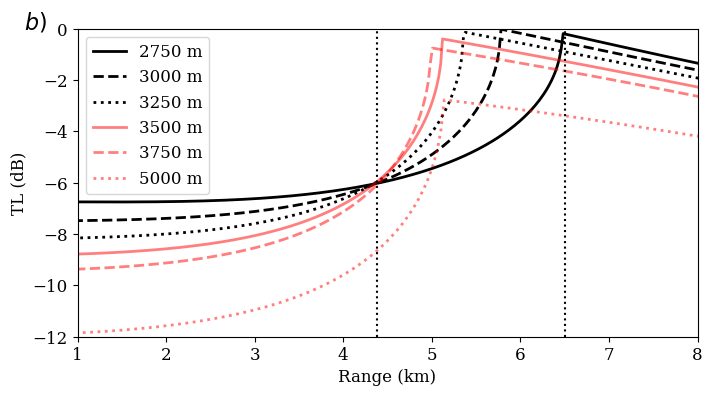

In [26]:
import numpy as np
from matplotlib import pyplot as plt

zSF = 2600 # Sea floor depth
zCrust = 3700 # Crust depth
cWater = 1500 # Water column sound speed
rhoCrust = 2 # Density of sediment just above crust

fig = plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

linetype = ['k','k--','k:','r','r--','r:']
linealpha = [1,1,1,0.5,0.5,0.5]

linecount = -1

for zCrust in [2750,3000,3250,3500,3750,5000]:
    
    linecount += 1
    rAll = []
    xAll = []
    AmpAll = []
    angAll = []

    for alpha0 in np.arange(89,10,-0.1):

        rSave = 0
        xSave = 0
        dz = 1
        Amp = 1
        alpha = alpha0*np.pi/180
        phi = np.sin(alpha)/cWater
        c1 = cWater*1
        c2 = c1*1

        z = 0

        while z <= zCrust:

            if z <= zSF:
                c2 = c1*1
                dx = dz/np.tan(alpha)
                dr = np.sqrt(dx**2 + dz**2)
                rSave += dr
                xSave += dx
                Amp = Amp*1 #0.99977
                z += dz
                alpha = np.arcsin( c2/c1 * np.sin(alpha) )
                if np.isnan(alpha) == True:
                    break
                c1 = c2*1

            elif z > zSF and z < zCrust:
                
                c2 = cWater + (0.25*(z-zSF))**1.2
                
                dx = dz/np.tan(alpha)
                dr = np.sqrt(dx**2 + dz**2)
                alpha = np.pi/2 - np.arcsin( c2/c1 * np.sin(np.pi/2 - alpha) )
                
                
                if np.isnan(alpha) == True:
                    Amp = Amp*1
                    rSave = rSave*2
                    xSave = xSave*2
                    xAll.append(xSave)
                    rAll.append(rSave)
                    AmpAll.append(Amp/rSave)
                    angAll.append(alpha0)
                    break
                c1 = c2*1
                rSave += dr
                xSave += dx
                Amp = Amp*(1)**(2*dr)
                z += dz

            elif z == zCrust:
                # print(z)
                cBot = c2*1.25
                rhoBot = 3
                if cBot*np.sin(np.pi/2-alpha)/c2 > 1:
                    R = 1
                else:
                    th_t = np.pi/2-np.arcsin(cBot*np.sin(np.pi/2-alpha)/c2)
                    R = (rhoBot*cBot/np.cos(np.pi/2-th_t) - rhoCrust*c2/np.cos(np.pi/2-alpha))/(rhoBot*cBot/np.cos(np.pi/2-th_t) + rhoCrust*c2/np.cos(np.pi/2-alpha))
                # print(R)
                Amp = Amp*np.abs(R)
                rSave = rSave*2
                xSave = xSave*2
                xAll.append(xSave/1e3)
                rAll.append(rSave)
                AmpAll.append(Amp/rSave**1)
                angAll.append(alpha0)
                z += dz

    plt.plot(xAll,20*np.log10(AmpAll)+78.4,linetype[linecount],linewidth=2,alpha=linealpha[linecount])
    
plt.plot([4.38,4.38],[-12,0],'k:')
plt.plot([6.5,6.5],[-12,0],'k:')
plt.legend(['2750 m','3000 m','3250 m','3500 m','3750 m','5000 m'])
plt.xlim([1,8])
plt.ylim([-12,0])
plt.xlabel('Range (km)')
plt.ylabel('TL (dB)')
plt.text(0.4, 0, r'$\it{b})$', fontsize = 16)
# plt.xscale('log')
plt.show()


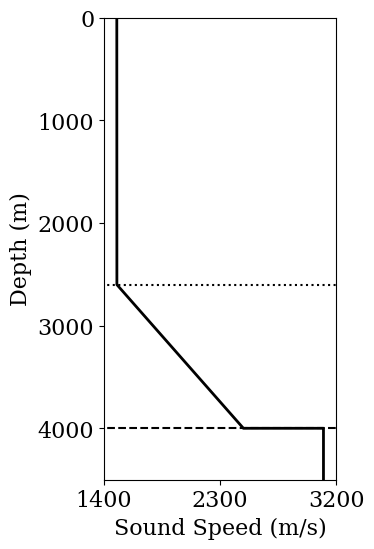

In [27]:
# Sound Speed Profile

cWater = 1500
zSF = 2600
zMax = 4000
zTmp = np.concatenate( ( np.arange(0,2601,1) , np.arange(2600,zMax+1) , np.arange(zMax,zMax+501) ) )
cTmp = np.concatenate( (np.ones(2601)*1500 , cWater + (0.7*(np.arange(2600,zMax+1)-zSF))**1.0 , np.ones(501)*3100 ) )

fig = plt.figure(figsize=(3,6))
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.plot(cTmp,zTmp,'k',linewidth=2)
plt.plot([1000,4000],[4000,4000],'k--')
plt.plot([1000,4000],[2600,2600],'k:')
plt.gca().invert_yaxis()
plt.xlabel( 'Sound Speed (m/s)' )
plt.ylabel( 'Depth (m)' )
plt.xlim([1400,3200])
plt.ylim([4500,0])
plt.yticks([0,1000,2000,3000,4000])
plt.xticks([1400,2300,3200])
plt.show()